In [8]:
import numpy as np
from utils import oned_well, functions
import matplotlib.pyplot as plt
from alive_progress import alive_bar


In [25]:
generations = 500
generation_size = 100000
n_best = 1000
n_variables = 25
well_length = 5
convergence_threshold = 0.000001

# TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# TODO: añadir visualización de la pérdida
# TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# TODO: por que se estropea para muchos puntos :(((
# Initialization
population = np.random.random([generation_size, n_variables])
mean_elite_scores = []
elite_stds = []

# Generation loop
with alive_bar(
    0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
) as bar:
    for generation in range(generations):
        bar()
        # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
        scores = functions.parallel_apply_along_axis(oned_well.compute_z_triangles, 1, population)
        # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)
        min_scores_index = np.argpartition(scores, n_best)[:n_best]
        best_individuals = population[min_scores_index]
        best_individuals_mean = best_individuals.transpose().mean(axis=1)
        best_individuals_std = best_individuals.transpose().std(axis=1)
        mean_elite_score = scores[min_scores_index].mean()
        elite_std = best_individuals_std.max()
        bar.text("- elite mean score: {:.7f}, elite std: {:.9f}".format(mean_elite_score, elite_std))
        mean_elite_scores.append(mean_elite_score)
        elite_stds.append(elite_std)
        if best_individuals_std.max() < convergence_threshold:
            population = best_individuals
            break
        else:
            population = np.random.normal(
                best_individuals_mean,
                best_individuals_std,
                [generation_size, n_variables],
            )

       ><('> 46 in 38s - elite mean score: 0.0442755, elite std: 0.000522516    

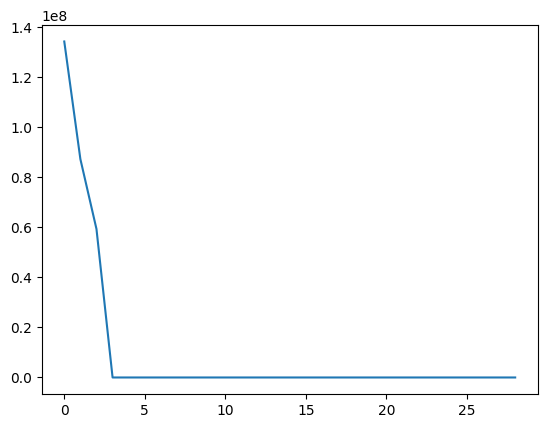

In [22]:
plt.plot(mean_elite_scores)

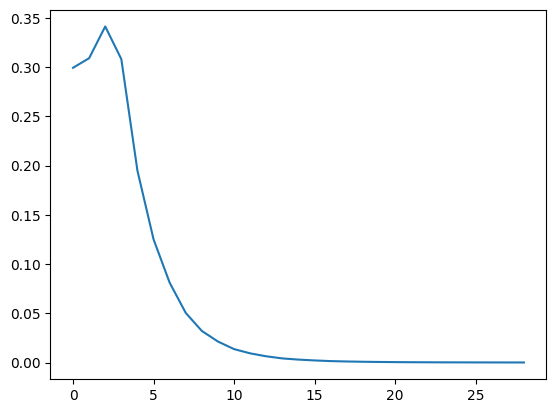

In [23]:
plt.plot(elite_stds)

In [24]:
# scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
scores = functions.parallel_apply_along_axis(oned_well.compute_z_triangles, 1, population)
best_score = min(scores)
best_individual = population[np.argmin(scores)]
print(best_score)

0.037507703216683785


In [20]:
def Psi_n(n):
    return (2 / well_length) ** 0.5 * np.sin(
        n * np.pi * np.linspace(0, well_length, n_variables) / well_length
    )


integral = 0
for i in range(len(best_individual)):
    integral = integral + (best_individual[i] ** 2) * (well_length / (n_variables - 1))

B = (1 / integral) ** 0.5
best_individual = B * best_individual

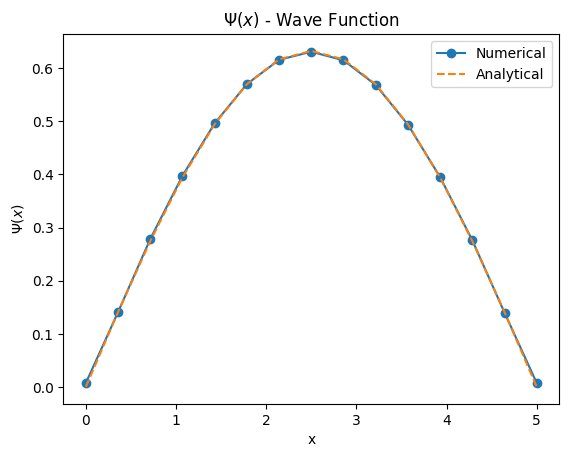

In [21]:
plt.plot(np.linspace(0, 5, n_variables), best_individual, label="Numerical", marker = "o")
plt.plot(np.linspace(0, 5, n_variables), Psi_n(1), "--", label="Analytical")
plt.gca().set_title("$\Psi(x)$ - Wave Function")
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("$\Psi(x)$")
plt.legend()